In [1]:
# ============================================================
# SETUP — Run this first!
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import random

# Verify versions
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version:      {np.__version__}")

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPU available: {gpus[0].name}")
else:
    print("\n⚠️  No GPU detected. Go to Runtime → Change runtime type → T4 GPU")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

TensorFlow version: 2.16.2
NumPy version:      1.26.4

✅ GPU available: /physical_device:GPU:0
Num GPUs Available:  1


In [2]:
import kagglehub

dataset_path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print(f"Dataset downloaded to: {dataset_path}")

# Print structure to understand folder layout
print("\nDataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = '  ' * level
    print(f"{indent}{os.path.basename(root)}/  ({len(files)} files)")
    if level >= 3:
        continue


Dataset downloaded to: /Users/mpersson/.cache/kagglehub/datasets/mahmoudreda55/satellite-image-classification/versions/1

Dataset structure:
1/  (1 files)
  data/  (1 files)
    cloudy/  (1500 files)
    water/  (1500 files)
    green_area/  (1500 files)
    desert/  (1092 files)


In [3]:
import hashlib

def file_hash(path, chunk_size=8192):
    hasher = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            hasher.update(chunk)
    return hasher.hexdigest()

seen = {}
duplicates = []

for root_dir, _, file_list in os.walk(dataset_path):
    for fname in file_list:
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        fpath = os.path.join(root_dir, fname)
        h = file_hash(fpath)
        if h in seen:
            duplicates.append(fpath)
        else:
            seen[h] = fpath

for dup in duplicates:
    os.remove(dup)

print(f"Total images scanned: {len(seen) + len(duplicates)}")
print(f"Duplicates removed: {len(duplicates)}")
print(f"Unique images remaining: {len(seen)}")

Total images scanned: 5592
Duplicates removed: 0
Unique images remaining: 5592


In [4]:
data_dir = os.path.join(dataset_path, "data")

batch_size = 32
img_size = (64, 64)
seed = 42

full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)
class_names = full_ds.class_names
print("Class names:", class_names)

# Inspect a single batch
for images, labels in full_ds.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

# Class distribution in full_ds
num_classes = len(class_names)
class_counts = np.zeros(num_classes, dtype=int)

for _, labels in full_ds:
    class_counts += np.bincount(labels.numpy(), minlength=num_classes)

for name, count in zip(class_names, class_counts):
    print(f"{name}: {count}")

full_ds = full_ds.shuffle(1000, seed=seed, reshuffle_each_iteration=False)

total_batches = tf.data.experimental.cardinality(full_ds).numpy()
test_batches = max(1, total_batches // 10)
val_batches = max(1, total_batches // 10)

test_ds = full_ds.take(test_batches)
val_ds = full_ds.skip(test_batches).take(val_batches)
train_ds = full_ds.skip(test_batches + val_batches)

print(f"Train batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Val batches:   {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test batches:  {tf.data.experimental.cardinality(test_ds).numpy()}")

Found 5592 files belonging to 4 classes.
Class names: ['cloudy', 'desert', 'green_area', 'water']
Images batch shape: (32, 64, 64, 3)
Labels batch shape: (32,)


2026-02-14 12:52:55.031889: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-02-14 12:52:55.031912: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-14 12:52:55.031920: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2026-02-14 12:52:55.031937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-14 12:52:55.031946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2026-02-14 12:52:55.077296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


cloudy: 1500
desert: 1092
green_area: 1500
water: 1500
Train batches: 141
Val batches:   17
Test batches:  17


2026-02-14 12:52:55.266246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2026-02-14 12:52:55.454923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Images batch shape: (32, 64, 64, 3)
Labels batch shape: (32,)
cloudy: 1193
desert: 891
green_area: 1207
water: 1213


2026-02-14 12:52:55.634511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


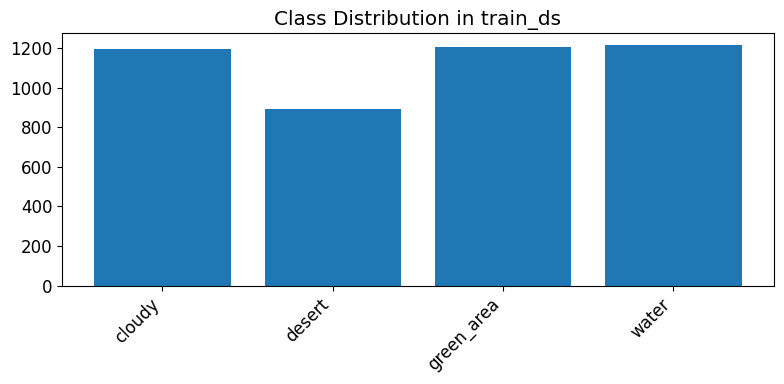

2026-02-14 12:52:56.062381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


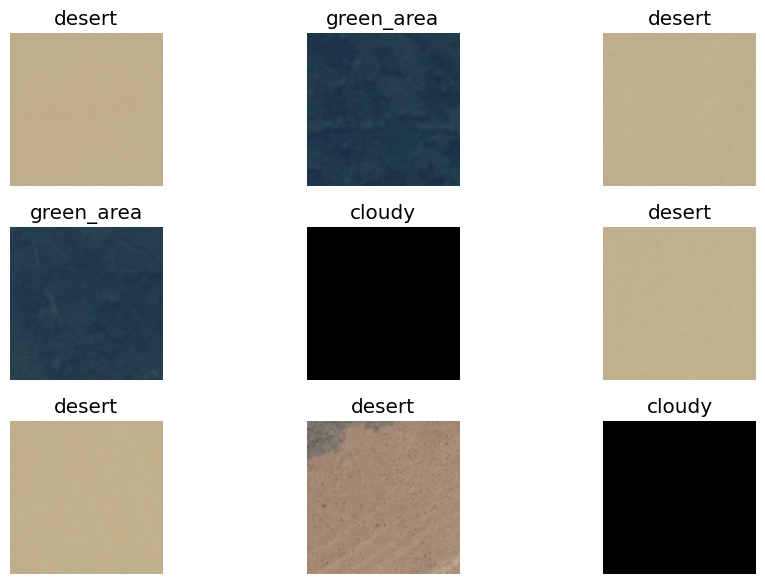

In [5]:
# Basic EDA on train_ds: batch shapes and class distribution


# Inspect a single batch
for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

# Class distribution in train_ds
num_classes = len(class_names)
class_counts = np.zeros(num_classes, dtype=int)

for _, labels in train_ds:
    class_counts += np.bincount(labels.numpy(), minlength=num_classes)

for name, count in zip(class_names, class_counts):
    print(f"{name}: {count}")

# Plot class distribution
plt.figure(figsize=(8, 4))
plt.bar(class_names, class_counts)
plt.title("Class Distribution in train_ds")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Visualize a few sample images
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
# Optimize data pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print("✅ Data pipeline optimized")

✅ Data pipeline optimized


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,716 (2.61 MB)

 Trainable params: 683,716 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7893 - loss: 2.6589 - val_accuracy: 0.7923 - val_loss: 0.4153
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8615 - loss: 0.3069 - val_accuracy: 0.9062 - val_loss: 0.1895
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9028 - loss: 0.2387 - val_accuracy: 0.9154 - val_loss: 0.1803
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8996 - loss: 0.2244 - val_accuracy: 0.9044 - val_loss: 0.2061
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9196 - loss: 0.1847 - val_accuracy: 0.9210 - val_loss: 0.1557
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8870 - loss: 0.2851 - val_accuracy: 0.9154 - val_loss: 0.1982
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9172 - loss: 0.2048 - val_accuracy: 0.9522 - val_loss: 0.1165
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9365 - loss: 0.1499 - val_accu

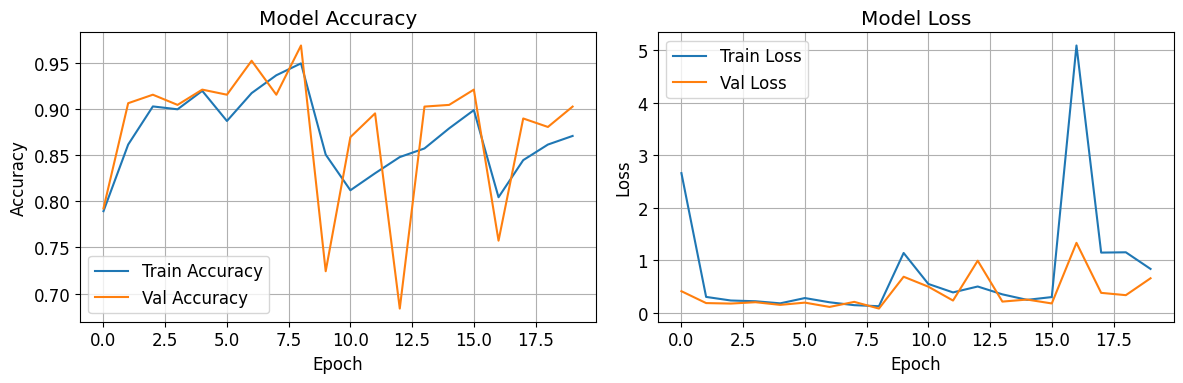

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8915 - loss: 0.7741

Test Accuracy: 0.8915
Test Loss: 0.7741


In [8]:
# Build CNN model
model = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")